<a href="https://colab.research.google.com/github/rmartimarly/teaching_misc/blob/main/AMIA-15class.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## AMIA module 2 class  classifier for the challenge

https://www.kaggle.com/competitions/amia-public-challenge-2024/

Robert Martí robert.marti@udg.edu


In [ ]:
import os
# from skimage import exposure
import pandas as pd; pd.options.mode.chained_assignment = None
import numpy as np
import scipy

import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim
from PIL import Image

Start loading dataset


In [ ]:
#LOAD THE NEW TRAIN AND TEST
# Define the paths to the training and testing dicom folders respectively
# DATA_DIR = "/home/robert/data/x-ray"
DATA_DIR = "/home/robert/data/amia_challenge/"
TRAIN_DIR = os.path.join(DATA_DIR, "train")
TEST_DIR = os.path.join(DATA_DIR, "test")


# Capture all the relevant full train/test paths
TRAIN_DICOM_PATHS = [os.path.join(TRAIN_DIR, f_name) for f_name in os.listdir(TRAIN_DIR)]
TEST_DICOM_PATHS = [os.path.join(TEST_DIR, f_name) for f_name in os.listdir(TEST_DIR)]
print(f"\n... The number of training files is {len(TRAIN_DICOM_PATHS)} ...")
print(f"... The number of testing files is {len(TEST_DICOM_PATHS)} ...")

# Define paths to the relevant csv files
TRAIN_CSV = os.path.join(DATA_DIR, "train.csv")
# SS_CSV = os.path.join(DATA_DIR, "sample_submission.csv")

# Create the relevant dataframe objects
train_df = pd.read_csv(TRAIN_CSV)
# ss_df_org = pd.read_csv(SS_CSV)

print("\n\nTRAIN DATAFRAME\n\n")
display(train_df.head(3))


TEST_CSV = os.path.join(DATA_DIR, "test.csv")
# SS_CSV = os.path.join(DATA_DIR, "sample_submission.csv")
# Create the relevant dataframe objects
test_df = pd.read_csv(TEST_CSV)


IMG_SIZE_CSV = os.path.join(DATA_DIR, "img_size.csv")
img_size_df = pd.read_csv(IMG_SIZE_CSV)



... The number of training files is 8573 ...
... The number of testing files is 6427 ...


TRAIN DATAFRAME




,image_id,class_name,class_id,rad_id,x_min,y_min,x_max,y_max
0,bM8C97htulC9fHKIDurJHquCXr1KZuug,No finding,14,R5,NaN,NaN,NaN,NaN
1,0FDQVdLgDKI1sRnPL94LzVh9EvXDVM9m,Aortic enlargement,0,R10,1148.0,503.0,1466.0,823.0
2,Dwk2TnGJFaMhyi3OfCrhdZG9ppGglC5w,Consolidation,4,R8,264.0,732.0,550.0,1119.0


Custom dataset in pytorch

In [ ]:
batch_size = 256

In [ ]:
# Define transformations for the images
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    transforms.Grayscale(num_output_channels=3)
])

# Define a custom dataset class
class CustomDataset(Dataset):
    def __init__(self, dataframe, root_dir, transform=None, train=True):
        self.dataframe = dataframe
        self.root_dir = root_dir
        self.transform = transform
        self.train = train

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_name = self.dataframe.iloc[idx, 0] + '.png'  # Assuming images are stored as png files
        img_path = os.path.join(self.root_dir, img_name)
        image = Image.open(img_path)
        #convert to color
        # Convert to RGB if the image is grayscale
        if image.mode != 'RGB':
            image = image.convert('RGB')
        if self.train:
#             if (self.dataframe.iloc[idx, 2]==14):
#                 class_id = 0 # normal
#             else:
#                 class_id = 1 # lesion
            class_id = self.dataframe.iloc[idx, 2]  # Class ID
        else:
            class_id = 0 # we don't know the label for the test.
        if self.transform:
                image = self.transform(image)

        return image, class_id


In [ ]:
# Create custom datasets and dataloaders
train_dataset = CustomDataset(dataframe=train_df, root_dir=TRAIN_DIR, train=True, transform=transform)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)


In [ ]:
# Define model architecture
model = models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features
# model.fc = nn.Linear(num_ftrs, 2)  # Binary classification
model.fc = nn.Linear(num_ftrs, 15)  # Binary classification


# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model
num_epochs = 5
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

/home/robert/anaconda3/envs/fast2/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/robert/anaconda3/envs/fast2/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


cuda:0


In [ ]:
model.to(device)
model.train()

for epoch in range(num_epochs):
    running_loss = 0.0
    for i, (inputs, labels) in enumerate(train_dataloader, 0):  # Unpack data from dataloader
        inputs, labels = inputs.to(device), labels.to(device)  # Move data to device

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 10 == 9:    # Print every 10 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 10))
            running_loss = 0.0

print('Finished Training')


[1,    10] loss: 2.037
[1,    20] loss: 1.640
[1,    30] loss: 1.579
[1,    40] loss: 1.558
[1,    50] loss: 1.494
[1,    60] loss: 1.532
[1,    70] loss: 1.462
[1,    80] loss: 1.453
[1,    90] loss: 1.356
[1,   100] loss: 1.415
[1,   110] loss: 1.371
[1,   120] loss: 1.421
[1,   130] loss: 1.359
[1,   140] loss: 1.340
[1,   150] loss: 1.391
[1,   160] loss: 1.364
[1,   170] loss: 1.365
[1,   180] loss: 1.376
[2,    10] loss: 1.232
[2,    20] loss: 1.295
[2,    30] loss: 1.277
[2,    40] loss: 1.253
[2,    50] loss: 1.318
[2,    60] loss: 1.304
[2,    70] loss: 1.267
[2,    80] loss: 1.257
[2,    90] loss: 1.240
[2,   100] loss: 1.277
[2,   110] loss: 1.221
[2,   120] loss: 1.265
[2,   130] loss: 1.283
[2,   140] loss: 1.292
[2,   150] loss: 1.263
[2,   160] loss: 1.192
[2,   170] loss: 1.302
[2,   180] loss: 1.264
[3,    10] loss: 1.170
[3,    20] loss: 1.167
[3,    30] loss: 1.165
[3,    40] loss: 1.188
[3,    50] loss: 1.170
[3,    60] loss: 1.201
[3,    70] loss: 1.160
[3,    80] 

In [ ]:
# torch.save(model.state_dict(), 'amia-15class_inference.pth')

In [ ]:
# torch.save(model,'amia-2class.pth')


In [ ]:
test_dataset = CustomDataset(dataframe=test_df, root_dir=TEST_DIR,train=False,transform=transform)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size,shuffle=False)

In [ ]:
print(len(test_dataloader))
print(len(train_dataloader))

86
180


In [ ]:
model.load_state_dict(torch.load("amia-15class_inference.pth"))


<All keys matched successfully>

In [ ]:
import torch.nn.functional as F
# Inference on the test dataset
model.eval()
test_predictions = []
test_probabilities = []
with torch.no_grad():
    for i, data in enumerate (test_dataloader):
        print("doing batch",i)
        # Unpack the data batch
        inputs, _ = data  # Assuming data is a tuple (images, labels)

        # Move inputs to the device
        inputs = inputs.to(device)

        # Move model to the same device as inputs
        model = model.to(device)

        # Perform inference
        outputs = model(inputs)

        # Get predictions
        _, predicted = torch.max(outputs, 1)

        # Get class probabilities
        probabilities,_ = torch.max(F.softmax(outputs, dim=1),1)

        # Convert tensors to CPU numpy arrays
        test_predictions.extend(predicted.cpu().numpy())
        test_probabilities.extend(probabilities.cpu().numpy())
#         print (test_probabilities)
# Assuming you want to add predictions to the test dataframe
test_df['predicted_class'] = test_predictions
test_df['probabilities'] = test_probabilities
print(test_df.head())


doing batch 0
doing batch 1
doing batch 2
doing batch 3
doing batch 4
doing batch 5
doing batch 6
doing batch 7
doing batch 8
doing batch 9
doing batch 10
doing batch 11
doing batch 12
doing batch 13
doing batch 14
doing batch 15
doing batch 16
doing batch 17
doing batch 18
doing batch 19
doing batch 20
doing batch 21
doing batch 22
doing batch 23
doing batch 24
doing batch 25
doing batch 26
doing batch 27
doing batch 28
doing batch 29
doing batch 30
doing batch 31
doing batch 32
doing batch 33
doing batch 34
doing batch 35
doing batch 36
doing batch 37
doing batch 38
doing batch 39
doing batch 40
doing batch 41
doing batch 42
doing batch 43
doing batch 44
doing batch 45
doing batch 46
doing batch 47
doing batch 48
doing batch 49
doing batch 50
doing batch 51
doing batch 52
doing batch 53
doing batch 54
doing batch 55
doing batch 56
doing batch 57
doing batch 58
doing batch 59
doing batch 60
doing batch 61
doing batch 62
doing batch 63
doing batch 64
doing batch 65
doing batch 66
doing

In [ ]:
# # Function to get the maximum value from a list
# def get_max_value(lst):
#     return max(lst)

# # Apply the function to the vector column to get the maximum value
# test_df['Prob'] = test_df['probabilities'].apply(get_max_value)

# print(test_df)

                               image_id  predicted_class  \
0      3r9OdPSdvQ58qI3VUFUeSKyCvxBpFc0c                1   
1      LO2jAm8E96Ih87wJVoqiOXHixrwPMeOm                0   
2      PN7S4HbhNp4fht9TTc6DXGOKGkeRTR7W                0   
3      l7f2KDvrnrh26v4aYgi0Slj7lVBZMQIL                1   
4      if5Pqu95xLUtURzAo72YiSg8GNzJb1F3                0   
...                                 ...              ...   
21984  k576EmhRJuLOIBHFyzH7LRcr2JbYFnHM                0   
21985  yFiQoOEOTP6yO3KMmiAQ5zkBjdww7icn                1   
21986  yg7B1t1DO9tMk2uJV0SkqA82y97SPZHa                0   
21987  1oO2FHrNonZqP9i854X6sio2hZj4R4h0                1   
21988  8Q8fPobVc11InzzHAKDfjH2emkfnEdnC                0   

                     probabilities      Prob  
0      [2.0238736e-05, 0.99997973]  0.999980  
1      [0.99999726, 2.7123774e-06]  0.999997  
2       [0.9998671, 0.00013289662]  0.999867  
3        [0.056354914, 0.94364506]  0.943645  
4         [0.9955727, 0.004427249]  0.995573

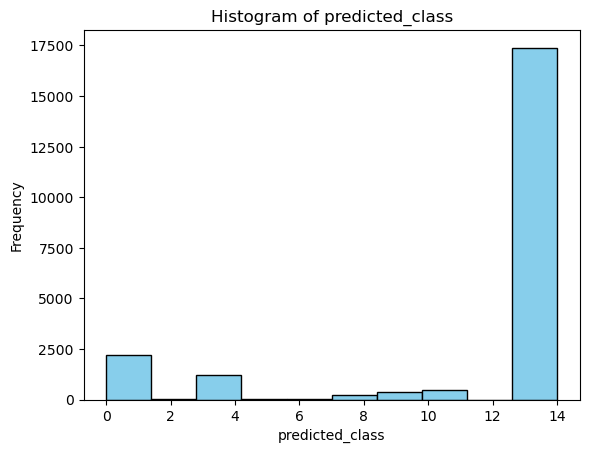

In [ ]:


# Specify the column name for which you want to plot the histogram
column_name = 'predicted_class'

# Plot the histogram
plt.hist(test_df[column_name], bins=10, color='skyblue', edgecolor='black')

# Add labels and title
plt.xlabel(column_name)
plt.ylabel('Frequency')
plt.title('Histogram of ' + column_name)

# Show the plot
plt.show()


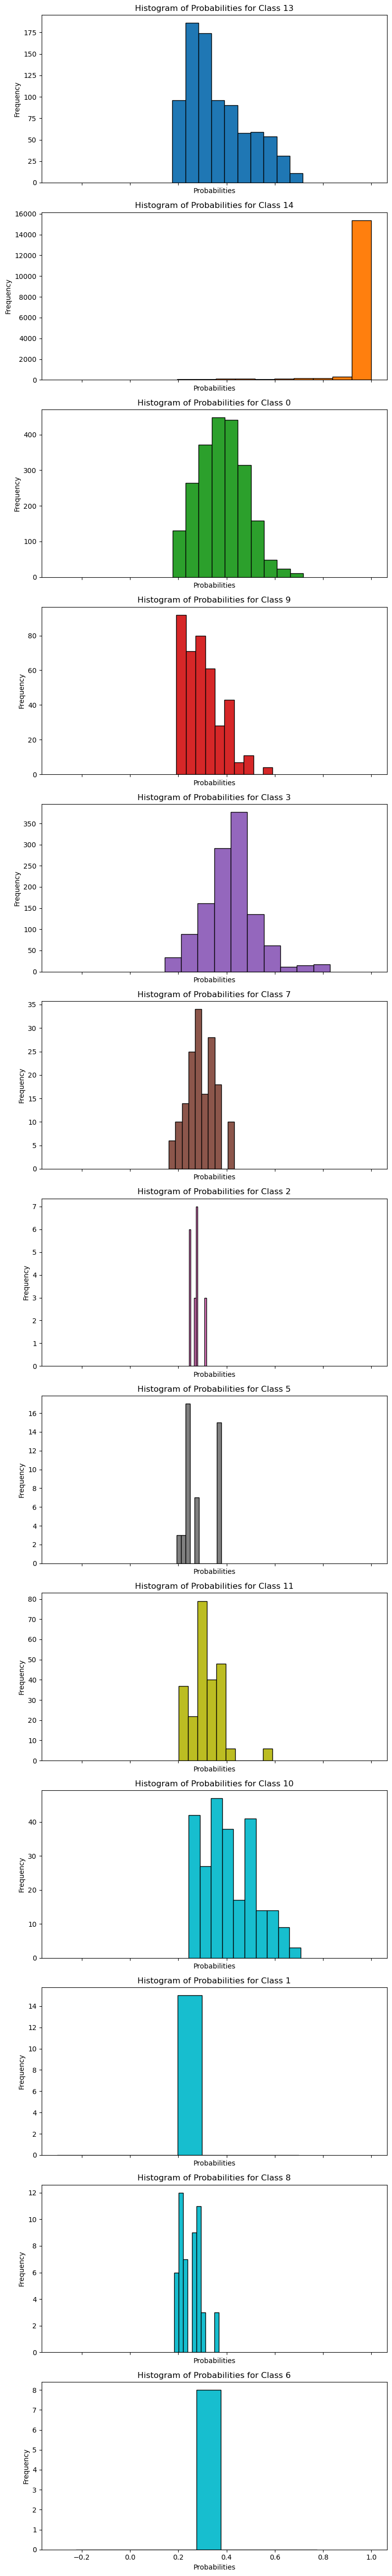

In [ ]:
# Get unique class labels
classes = test_df['predicted_class'].unique()

# Create subplots for each class
fig, axs = plt.subplots(len(classes), 1, figsize=(8, len(classes)*4), sharex=True)

# Define a colormap
cmap = plt.cm.get_cmap('tab10')

# Plot histograms for each class
for i, cls in enumerate(classes):
    # Filter data for the current class
    data = test_df[test_df['predicted_class'] == cls]['probabilities']
    # Plot histogram with a unique color for each class
    axs[i].hist(data, bins=10, color=cmap(i), edgecolor='black')

    # Add labels and title
    axs[i].set_xlabel('Probabilities')
    axs[i].set_ylabel('Frequency')
    axs[i].set_title('Histogram of Probabilities for Class {}'.format(cls))

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

In [ ]:
test_df = pd.read_csv('test_predictions.csv')
test_df.head()

# change 0 for 14
# change 1 for 0
test_df['predicted_class'] = test_df['predicted_class'].replace(0, 14)
test_df['predicted_class'] = test_df['predicted_class'].replace(1, 0)

def prepare_pred(row):
    prob = str(row['Prob']) if not pd.isna(row['Prob']) else '0'  # Convert NaN to '0'
    if row['predicted_class'] == 14: # is normal let's return test_df['Prob'].astype(str) + 0 0 1 1
        return '14 '+ prob + ' 0 0 1 1'
    else:
        return row['predicted_class'] + ' ' + prob + ' 700 700 1000 1000'

# Apply the function to add text to specific rows
test_df['PredictionString'] = test_df.apply(prepare_pred, axis=1)

# # Create a new column by concatenating 'predicted_class' and 'Prob' as strings
# test_df['PredictionString'] = test_df['predicted_class'].astype(str) + ' ' + test_df['Prob'].astype(str) + ' 0 0 1 1'

# Create a new DataFrame with 'image_id' and 'new_column'
test_df_submit = test_df[['image_id', 'PredictionString']]

print(test_df_submit)

test_df_submit = test_df_submit.drop_duplicates()
# duplicate_rows = test_df_submit[test_df_submit.duplicated()]

# if duplicate_rows.empty:
#     print("No duplicate rows found.")
# else:
#     print("Duplicate rows found:")
#     print(duplicate_rows)
test_df_submit.to_csv('test_predictions_submit.csv', index=False)
print(test_df_submit)

                               image_id       PredictionString
0      3r9OdPSdvQ58qI3VUFUeSKyCvxBpFc0c  14 0.99997973 0 0 1 1
1      LO2jAm8E96Ih87wJVoqiOXHixrwPMeOm  14 0.99999726 0 0 1 1
2      PN7S4HbhNp4fht9TTc6DXGOKGkeRTR7W   14 0.9998671 0 0 1 1
3      l7f2KDvrnrh26v4aYgi0Slj7lVBZMQIL  14 0.94364506 0 0 1 1
4      if5Pqu95xLUtURzAo72YiSg8GNzJb1F3   14 0.9955727 0 0 1 1
...                                 ...                    ...
21984  k576EmhRJuLOIBHFyzH7LRcr2JbYFnHM  14 0.99922645 0 0 1 1
21985  yFiQoOEOTP6yO3KMmiAQ5zkBjdww7icn   14 0.9631196 0 0 1 1
21986  yg7B1t1DO9tMk2uJV0SkqA82y97SPZHa   14 0.9986688 0 0 1 1
21987  1oO2FHrNonZqP9i854X6sio2hZj4R4h0  14 0.77643305 0 0 1 1
21988  8Q8fPobVc11InzzHAKDfjH2emkfnEdnC  14 0.99512476 0 0 1 1

[21989 rows x 2 columns]
                               image_id       PredictionString
0      3r9OdPSdvQ58qI3VUFUeSKyCvxBpFc0c  14 0.99997973 0 0 1 1
1      LO2jAm8E96Ih87wJVoqiOXHixrwPMeOm  14 0.99999726 0 0 1 1
2      PN7S4HbhNp4fht9TTc6DXG

In [ ]:
print(test_df.describe())
# Save the DataFrame to a CSV file
test_df.to_csv('test_predictions.csv', index=False)

       predicted_class          Prob
count     21989.000000  21989.000000
mean          9.560417      0.967361
std           6.515075      0.088804
min           0.000000      0.501167
25%           0.000000      0.992792
50%          14.000000      0.999810
75%          14.000000      0.999995
max          14.000000      1.000000
